In [54]:
import pandas as pd
import re
import gensim
from gensim.parsing.preprocessing import remove_stopwords
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import collections
from datetime import datetime
import math


In [55]:
df = pd.read_csv("cleaned_pages.csv")
pages = []

for rows in df.iterrows() :
    pages.append([rows[1][0],rows[1][1]])

pages_train , pages_test = train_test_split( pages , test_size=0.10, random_state=42)

fields = ["Text","Result"]

df_train = pd.DataFrame(data = pages_train, columns= fields)
df_test = pd.DataFrame(data = pages_test, columns= fields)

In [56]:
def word_2_vector( df ) :
    print("df len inside w2v is : " , len(df) , "\n" )
    tokenized_pages = df.text.apply(lambda x: x.split()) # tokenizing
    print("len of tokenized tweets : " , len(tokenized_pages) , "\n" )
    if not ( len(df) == len(tokenized_pages) ) :
        return 1
    model_w2v = gensim.models.Word2Vec(
    tokenized_pages,
    vector_size= 256, # desired no. of features/independent variables
    window=5, # context window size
    min_count=1,
    sg = 1, # 1 for skip-gram model
    hs = 0,
    negative = 10, # for negative sampling
    workers= 2, # no.of cores
    seed = 34)
    model_w2v.train(tokenized_pages, total_examples= len(df), epochs=20)
    # Creating vectors for the tweets using the tweet's words
    pages_w2v = []
    for tokenized_tweet in tokenized_pages :
        vector_sum = [0]
        for word in tokenized_tweet :
            vector_sum = vector_sum + model_w2v.wv[word]
        for i in range(len(vector_sum)) :
            vector_sum[i] = vector_sum[i]/(len(tokenized_tweet) + 1 ) # μέσο διάνυσμα
        pages_w2v.append( vector_sum )

    return pages_w2v

In [57]:
clear_text = []
result = []

for pages in df_train.iterrows() :
    clear_text.append(pages[1][0])
    result.append(pages[1][1])

result_in_num = []

for cond in result : #Convert in and out to numerical value
    result_in_num.append(ord(cond[0]) + ord(cond[1]))

df_train = pd.DataFrame(data = clear_text, columns= ["text"] )
w2v_array = word_2_vector(df_train)

print("len w2v is : " , len(w2v_array) , "\n")

clear_text = []
result = []

for pages in df_test.iterrows() :
    clear_text.append(pages[1][0])
    result.append(pages[1][1])
    
result_in_num_test = []

for cond in result : #Convert in and out to numerical value
    result_in_num_test.append(ord(cond[0]) + ord(cond[1]))

df_test = pd.DataFrame(data = clear_text, columns= ["text"] )

w2v_array_test = word_2_vector(df_test)


df len inside w2v is :  194 

len of tokenized tweets :  194 

len w2v is :  194 

df len inside w2v is :  22 

len of tokenized tweets :  22 



In [58]:
import pandas as pd
import preprocessor as pr
import re
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim import models
import sklearn
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import collections
from datetime import datetime
import statistics
import numpy as np
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn import metrics


In [59]:
def cross_validation_KNN(parameters , vector_array , num_sentiments , elements) :

  parameter_means = []

  #parameters = [2 , 3 , 5 , 10 , 15 , 20 , 25]

  for parameter in parameters :
      print("Neighbours = " , parameter)
      clf = KNeighborsClassifier(n_neighbors= parameter)
      clf_cv = cross_validate( clf , vector_array[:elements] , num_sentiments[:elements] , scoring=  ["precision_micro" , "accuracy" , "recall_micro" , "f1_micro"], cv = 10)
      print("KNN w2v cv : "  , clf_cv)
      cv_metrics = np.array([clf_cv["test_precision_micro"] , clf_cv["test_accuracy"] , clf_cv["test_recall_micro"]
                          , clf_cv["test_f1_micro"]    ])
      cv_metrics = np.transpose(cv_metrics)
      print("[precision_micro , accuracy , reacall_micro , f1_micro]")
      print(cv_metrics)
      parameter_means.append( max( [ statistics.median( cv_metrics[i]) for i in range(len(cv_metrics))]) )

  print(parameter_means)
  best_knn_param = parameters[parameter_means.index(max(parameter_means))]
  print(best_knn_param)

  fig = plt.figure(13 ,figsize = (10, 10))
  plt.plot( parameters,  parameter_means )
  plt.scatter(parameters ,parameter_means , color = "r", marker = "o" )
  plt.xlabel("neigbours")
  plt.ylabel("Max mean of metrics' scores ")
  plt.title("KNN performance according to number of neighbours ")

Neighbours =  2
KNN w2v cv :  {'fit_time': array([0.00099945, 0.        , 0.        , 0.        , 0.        ,
       0.00100136, 0.        , 0.        , 0.0010016 , 0.        ]), 'score_time': array([0.00351214, 0.00300288, 0.0030005 , 0.00299764, 0.00299859,
       0.00199866, 0.00300002, 0.00199986, 0.00200033, 0.00200152]), 'test_precision_micro': array([0.8       , 0.9       , 1.        , 1.        , 0.94736842,
       0.94736842, 0.94736842, 0.89473684, 0.78947368, 0.94736842]), 'test_accuracy': array([0.8       , 0.9       , 1.        , 1.        , 0.94736842,
       0.94736842, 0.94736842, 0.89473684, 0.78947368, 0.94736842]), 'test_recall_micro': array([0.8       , 0.9       , 1.        , 1.        , 0.94736842,
       0.94736842, 0.94736842, 0.89473684, 0.78947368, 0.94736842]), 'test_f1_micro': array([0.8       , 0.9       , 1.        , 1.        , 0.94736842,
       0.94736842, 0.94736842, 0.89473684, 0.78947368, 0.94736842])}
[precision_micro , accuracy , reacall_micro , f1

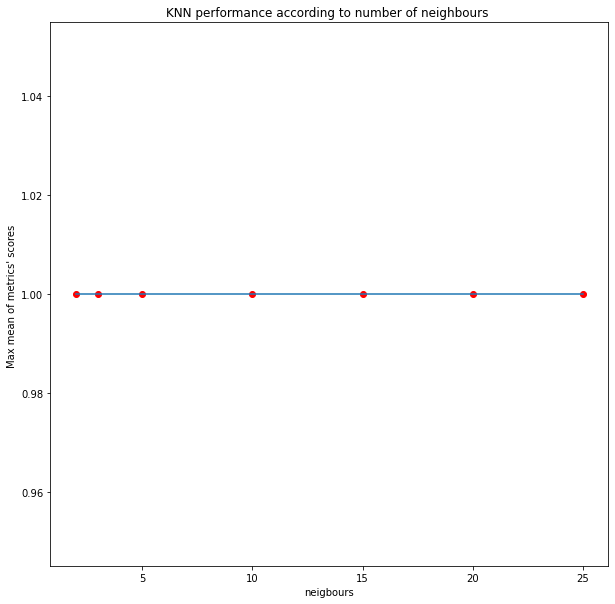

In [60]:
parameters = [2 , 3 , 5 , 10 , 15 , 20 , 25]
cross_validation_KNN(parameters , w2v_array , result_in_num , 194)

In [61]:
neigh = KNeighborsClassifier(n_neighbors = 5)
neigh.fit(w2v_array_test, result_in_num_test)
knn_w2v_pred = neigh.predict(w2v_array_test)
correct_knn = 0
for i in range(22) :
    if knn_w2v_pred[i] == result_in_num_test[i] :
        correct_knn = correct_knn + 1

print("Classification report for KNN prediction with w2v representation : ")
print(classification_report( result_in_num_test , knn_w2v_pred ))

Classification report for KNN prediction with w2v representation : 
              precision    recall  f1-score   support

         151       0.93      0.87      0.90        15
         164       0.75      0.86      0.80         7

    accuracy                           0.86        22
   macro avg       0.84      0.86      0.85        22
weighted avg       0.87      0.86      0.87        22

